<a href="https://colab.research.google.com/github/tushargupta123/deep-learning-practice/blob/main/transfer_learning_feature_extraction(without_data_augmentation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# feature extraction is used when we remove ann layers only and we know that the pretrained model containes the data that is required and we just want to modeify the classification criterion of model



In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

 98% 1.04G/1.06G [00:04<00:00, 251MB/s]
100% 1.06G/1.06G [00:04<00:00, 268MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [5]:
conv_base = VGG16(
    weights = 'imagenet',
    include_top = False,  # it will not include ann layers
    input_shape=(150,150,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
conv_base.trainable = False
# freezing parameters of cnn layers

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


# change of non trainable paramaters is due to the reason that we have now freezed the cnn layers training

In [11]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [12]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [13]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 [==============================] - 79s 106ms/step - loss: 0.2809 - accuracy: 0.8827 - val_loss: 0.2097 - val_accuracy: 0.9092
Epoch 2/10
625/625 [==============================] - 63s 101ms/step - loss: 0.1877 - accuracy: 0.9216 - val_loss: 0.2357 - val_accuracy: 0.9036
Epoch 3/10
625/625 [==============================] - 54s 86ms/step - loss: 0.1641 - accuracy: 0.9330 - val_loss: 0.2037 - val_accuracy: 0.9158
Epoch 4/10
625/625 [==============================] - 53s 84ms/step - loss: 0.1264 - accuracy: 0.9489 - val_loss: 0.2331 - val_accuracy: 0.9128
Epoch 5/10
625/625 [==============================] - 53s 84ms/step - loss: 0.1037 - accuracy: 0.9600 - val_loss: 0.2561 - val_accuracy: 0.9124
Epoch 6/10
625/625 [==============================] - 63s 101ms/step - loss: 0.0757 - accuracy: 0.9706 - val_loss: 0.2804 - val_accuracy: 0.9052
Epoch 7/10
625/625 [==============================] - 53s 85ms/step - loss: 0.0626 - accuracy: 0.9765 - val_loss: 0.3187 - val_accura

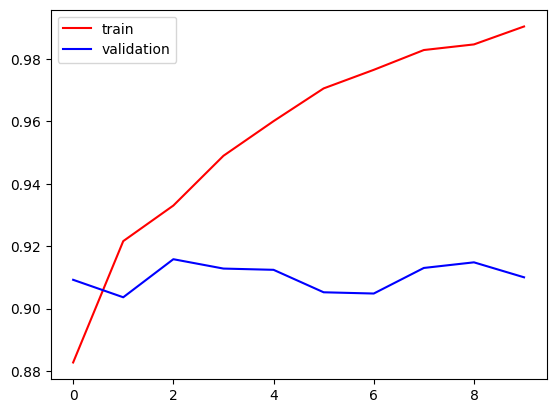

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

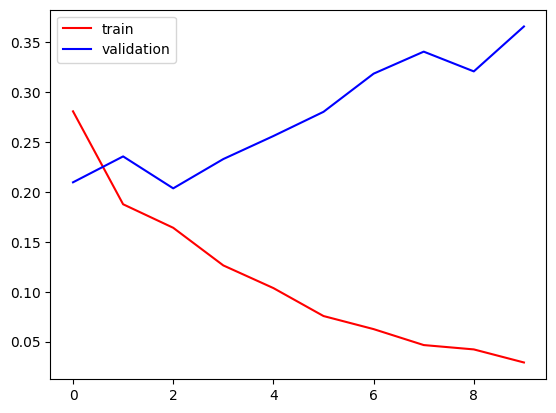

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# it is having overfitting so to remove it we will use data augmentation